# Setting Up Google Drive and Libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload 2

In [0]:
# All the supporting python files are saved in GDrive
import sys
sys.path.append('./gdrive/My Drive/EVA_Library/')

In [5]:
# Print library info. Not completely written yet
from TestLibraryVersion import PrintLibraryInfo
PrintLibraryInfo()

The current version of the Library is 1.1


In [6]:
from pyTorchChitra.cnnModels.new_resnet import PrintMyFileVersion

print(PrintMyFileVersion())

Hello there it is 1.4
None


In [7]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-r09ueqtu
Albumentation library is successfully installed!


In [8]:
from pyTorchChitra.cifarImageLoader.DatasetLoader import getCifar10Data, cifar10WithAlbumentations
from pyTorchChitra.cnnModels.new_resnet import NewResNet
from pyTorchChitra.cnnModels.model_summary import displayModelSummary
from pyTorchChitra.modelTraining.modelTraining import setup_ROP_Optimizer, runTheModel, modelTrainTestHistory
from pyTorchChitra.modelTraining.modelTraining import setup_OCLR_Optimizer
from pyTorchChitra.utils.utils import isCudaAvailable
from pyTorchChitra.modelTraining.lrFinder import LRFinder
from pyTorchChitra.gradCAM.visual import GradCAMView, plot_gradcam
from pyTorchChitra.utils.misClassfiedImages import misClassfied, displayMisClassfiedImages
from pyTorchChitra.cifarImageLoader.displayImages import displayDataSetSampleImages
!pip install torchsummary
#!pip install -U git+https://github.com/albu/albumentations


  pip install torch-lr-finder -v --global-option="amp"


# Understanding Learning Rate

This note-book uses one cycle policy (super convergence) for training the neural network. In order to understand the learning rate variation, a traingular wave is plotted below. This triangular wave is actually is for cyclic learning rates and not for One Cycle Policy. One cycle policy uses just one instance of the 'wave'. 

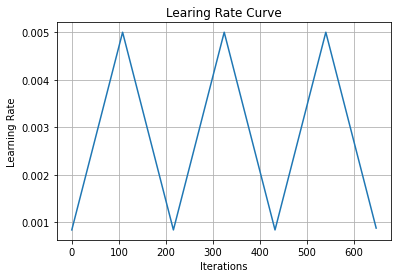

In [9]:
from pyTorchChitra.utils.CLR_data_calc import TriangularWavePlotter
plotter = TriangularWavePlotter(step_size = 108, min_bound = 0.00084, max_bound = 0.005)
plotter.generate_datapoints(num_curves = 3, draw_graph = True)

# Set the Arguments for project and Setup Train/Test Dataset 

In [0]:
# Arguments for the functions
class Args:
    # ---- Data Loader Arguments -----
    train_batch_size = 512
    test_batch_size = 512
    num_workers = 4
    dataset_mean = [0.4914, 0.4822, 0.4465]
    dataset_std = [0.2023, 0.1994, 0.2010]
    classes = ['plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class modelExtraSettings:
    '''Additional setting which are useful when debugging model '''
    RunLRFinder = False
    display_summary = True
  

In [11]:
# Get the Cifar-10 dataset and apply Ablumentation image augmentation techniques
train_loader, test_loader = cifar10WithAlbumentations(
                            batch_size = Args.train_batch_size, 
                            number_of_workers = Args.num_workers,
                            prob_transform = Args.num_workers  
                            )

Now downloading and allocating dataset
Cuda Available? cuda


Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Now allocating Dataloaders


In [12]:
# Display the sample images. Images will be saved in current directory
displayDataSetSampleImages(train_loader, Args.classes,
                           Args.dataset_mean, Args.dataset_std, 
                           num_of_images = 20)

torch.Size([512, 32, 32, 3])


<Figure size 720x720 with 0 Axes>

# Train the Model

In [13]:
device = isCudaAvailable()
print (device)

cuda


In [0]:
#from pyTorchChitra.cnnModels.vanillaCNN import plainArch

In [15]:
from pyTorchChitra.cnnModels.new_resnet import PrintMyFileVersion
PrintMyFileVersion()

model = NewResNet().to(device)
if modelExtraSettings.display_summary == True:
    displayModelSummary(model)

Hello there it is 1.4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 256, 16, 16]         294,912
        MaxPool2d-11            [-1, 256, 8, 8]               0
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 512, 8, 8]       1,179,648
        MaxPool2d

./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)


In [0]:
import torch.nn as nn
from torch.optim import SGD, Adam

if modelExtraSettings.RunLRFinder == True:
    criterion = nn.NLLLoss()
    optimizer = SGD(model.parameters(), lr=0.0001)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=3, num_iter=1000, step_mode="exp")


./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)



Learning rate search finished. See the graph with {finder_name}.plot()


0.0065048023980301024


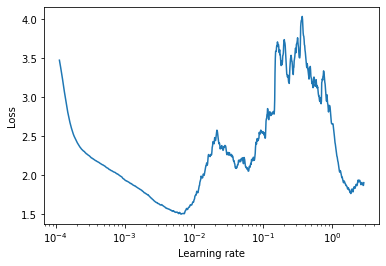

In [0]:
if modelExtraSettings.RunLRFinder == True:
    lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
    print (lr)
    lr_finder.plot()

In [0]:
optimizer, scheduler = setup_OCLR_Optimizer(model, device, total_steps = 2400, 
                                            num_raise = 0.209,div_factor = 6, max_lr = 0.005)

In [17]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.0008333333333333334


In [18]:
train_losses, train_acc, test_losses, test_acc = runTheModel(model=model, 
                                                            device=device, 
                                                            optimizer=optimizer, 
                                                            train_loader=train_loader, 
                                                            test_loader=test_loader, 
                                                            scheduler=scheduler,
                                                            epochs = 24, 
                                                            isOCLR = True,
                                                            )


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/new_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(Layer_4)
Loss=1.3795907497406006 Batch_id=97 Accuracy=39.70: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.2898, Accuracy: 5321/10000 (53.21%)
Validation loss to Schedular = 1.2898492492675782

EPOCH: 1


Loss=1.1001453399658203 Batch_id=97 Accuracy=59.80: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.0962, Accuracy: 6115/10000 (61.15%)
Validation loss to Schedular = 1.0961833160400392

EPOCH: 2


Loss=0.7194733023643494 Batch_id=97 Accuracy=68.24: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.9039, Accuracy: 6791/10000 (67.91%)
Validation loss to Schedular = 0.9039175842285156

EPOCH: 3


Loss=0.6563959121704102 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.9198, Accuracy: 6803/10000 (68.03%)
Validation loss to Schedular = 0.919767497253418

EPOCH: 4


Loss=0.7167820930480957 Batch_id=97 Accuracy=76.68: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7749, Accuracy: 7353/10000 (73.53%)
Validation loss to Schedular = 0.774885139465332

EPOCH: 5


Loss=0.5415088534355164 Batch_id=97 Accuracy=79.96: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6885, Accuracy: 7640/10000 (76.40%)
Validation loss to Schedular = 0.688494255065918

EPOCH: 6


Loss=0.5343164801597595 Batch_id=97 Accuracy=82.50: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6666, Accuracy: 7718/10000 (77.18%)
Validation loss to Schedular = 0.6666075012207031

EPOCH: 7


Loss=0.5084683299064636 Batch_id=97 Accuracy=85.04: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6060, Accuracy: 7943/10000 (79.43%)
Validation loss to Schedular = 0.6059646911621094

EPOCH: 8


Loss=0.34443366527557373 Batch_id=97 Accuracy=87.00: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6281, Accuracy: 7900/10000 (79.00%)
Validation loss to Schedular = 0.6281115142822266

EPOCH: 9


Loss=0.3664267957210541 Batch_id=97 Accuracy=88.50: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5594, Accuracy: 8111/10000 (81.11%)
Validation loss to Schedular = 0.5593908752441407

EPOCH: 10


Loss=0.26883479952812195 Batch_id=97 Accuracy=89.81: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5658, Accuracy: 8106/10000 (81.06%)
Validation loss to Schedular = 0.5658335983276367

EPOCH: 11


Loss=0.2077081948518753 Batch_id=97 Accuracy=91.52: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5780, Accuracy: 8083/10000 (80.83%)
Validation loss to Schedular = 0.5779908187866211

EPOCH: 12


Loss=0.23552000522613525 Batch_id=97 Accuracy=92.67: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5477, Accuracy: 8206/10000 (82.06%)
Validation loss to Schedular = 0.5476974922180176

EPOCH: 13


Loss=0.19971878826618195 Batch_id=97 Accuracy=93.77: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5515, Accuracy: 8216/10000 (82.16%)
Validation loss to Schedular = 0.5515004844665528

EPOCH: 14


Loss=0.13794930279254913 Batch_id=97 Accuracy=94.75: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5992, Accuracy: 8102/10000 (81.02%)
Validation loss to Schedular = 0.5991730789184571

EPOCH: 15


Loss=0.22899191081523895 Batch_id=97 Accuracy=95.54: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6131, Accuracy: 8139/10000 (81.39%)
Validation loss to Schedular = 0.6130855590820312

EPOCH: 16


Loss=0.09094297885894775 Batch_id=97 Accuracy=95.98: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5641, Accuracy: 8206/10000 (82.06%)
Validation loss to Schedular = 0.5641076797485352

EPOCH: 17


Loss=0.1520092636346817 Batch_id=97 Accuracy=96.56: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5535, Accuracy: 8261/10000 (82.61%)
Validation loss to Schedular = 0.5535141296386719

EPOCH: 18


Loss=0.10189670324325562 Batch_id=97 Accuracy=97.05: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5915, Accuracy: 8150/10000 (81.50%)
Validation loss to Schedular = 0.5914632186889649

EPOCH: 19


Loss=0.11862426996231079 Batch_id=97 Accuracy=97.62: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5477, Accuracy: 8339/10000 (83.39%)
Validation loss to Schedular = 0.5477470123291016

EPOCH: 20


Loss=0.08303914219141006 Batch_id=97 Accuracy=97.73: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5382, Accuracy: 8359/10000 (83.59%)
Validation loss to Schedular = 0.5381540420532227

EPOCH: 21


Loss=0.0671253353357315 Batch_id=97 Accuracy=98.12: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5711, Accuracy: 8288/10000 (82.88%)
Validation loss to Schedular = 0.5710507843017578

EPOCH: 22


Loss=0.07241646200418472 Batch_id=97 Accuracy=98.37: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5554, Accuracy: 8348/10000 (83.48%)
Validation loss to Schedular = 0.5554156219482422

EPOCH: 23


Loss=0.056852322071790695 Batch_id=97 Accuracy=98.50: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]


Test set: Average loss: 0.5470, Accuracy: 8372/10000 (83.72%)
Validation loss to Schedular = 0.547003645324707



2352


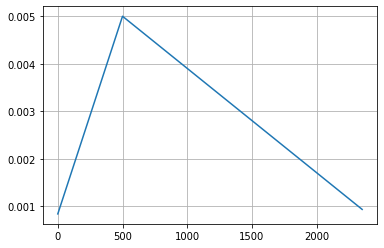

In [19]:
import matplotlib.pyplot as plt
from pyTorchChitra.utils.global_vars import cyclic_LR_history

print(len(cyclic_LR_history))
plt.plot(cyclic_LR_history)
plt.grid('both')

In [20]:
# Final Test Accuracy
test_acc[-1]

83.72

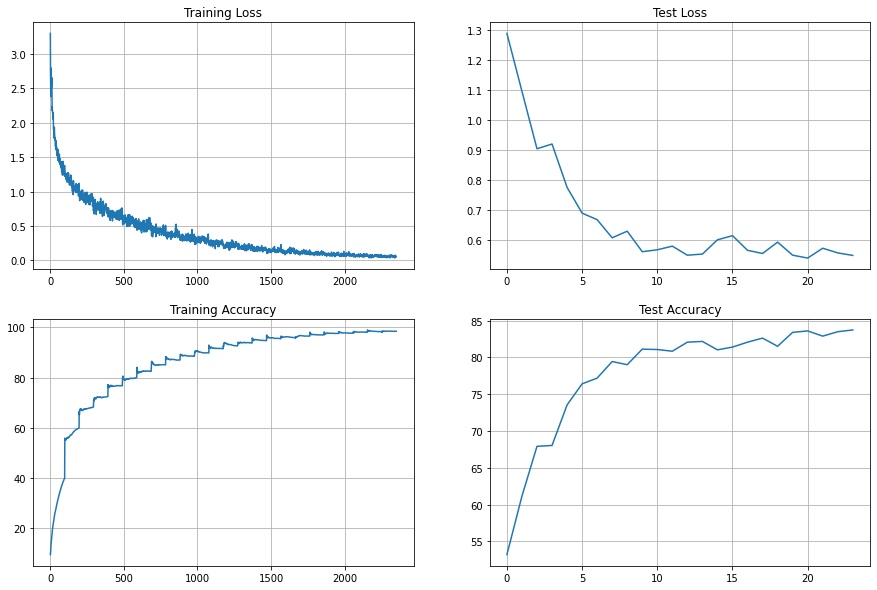

In [21]:
modelTrainTestHistory (train_losses, train_acc, test_losses, test_acc)

In [0]:
import torch
torch.save(model, './gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

In [0]:
#import torch
#torch.load('./gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

# Displaying the mis-classified images

In [0]:
ground_truth, classified_lie, my_misclassified_images = misClassfied(model=model, 
                                                                device=device, 
                                                                test_loader=test_loader, 
                                                                req_num_images=25)

ground_truth = ground_truth.numpy().squeeze().astype(int)
classified_lie = classified_lie.numpy().squeeze().astype(int)

# Not showing the mis-classified image here as it will be shown in GradCam
# Bug:<To-do>: displayMisClassfiedImages function de-normalizes the image; if the 'my_misclassified_images' sent as is to
# to the gradCam then images will fade
# displayMisClassfiedImages (ground_truth, Args.dataset_mean, Args.dataset_std, classified_lie, my_misclassified_images)

In [0]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']

grad_cam = GradCAMView(
    model, layers,
    device, Args.dataset_mean, Args.dataset_std,
)

gradcam_views = grad_cam(my_misclassified_images)

In [0]:
plot_gradcam(gradcam_views, layers, ground_truth, classified_lie, 'grad_cam')